## Movie Data Set Notebook #1 -- General Preprocessing

In [62]:
# General imports here.
import pandas as pd
import numpy as np
import sklearn as sk
import math
import ast
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
# Read the csv files and index appropriately.
#ratings_small_df = pd.read_csv('./data/ratings_small.csv')
#ratings_df = pd.read_csv('./data/ratings.csv')
#links_small_df = pd.read_csv('./data/links_small.csv')
#links_df = pd.read_csv('./data/links.csv')
keywords_df = pd.read_csv('./data/keywords.csv')
credits_df = pd.read_csv('./data/credits.csv')
metadata_df = pd.read_csv('./data/movies_metadata.csv')
# Reading the movies_metadata.csv file throws a DtypeWarning.
# It's the popularity feature. I deleted it.

In [64]:
print(metadata_df.id.unique())
print(metadata_df.id.dtype)
# If dtype is not int64, go to the metadata CSV and delete all entries where 'adult' is not false.
# I also deleted the adult column afterwards.

[   862   8844  15602 ...,  67758 227506 461257]
int64


In [65]:
# These three files seem to be the ones we want. Indexed on ID, we could probably combine them now.
dataframes = (keywords_df, credits_df, metadata_df)
# Pandas DataFrames don't have name attributes.
df_names = ("keywords", "credits", "movies_metadata")
keywords_df = keywords_df.set_index('id')
credits_df = credits_df.set_index('id')
metadata_df = metadata_df.set_index('id')
None

In [66]:
# Join the useful data frames together
temp = keywords_df.join(credits_df)
movie_df = metadata_df.join(temp)

In [67]:
# Here I'm just doing some of the same stuff "The Story of Film" did on Kaggle.
# This all makes sense, it's pretty standard.
movie_df = movie_df.drop(['imdb_id'], axis=1)
movie_df = movie_df.drop(['original_title'], axis=1)
movie_df = movie_df.drop(['video'], axis=1)
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
movie_df['poster_path'] = "<img src='" + base_poster_url + movie_df['poster_path'] + "' style='height:100px;'>"

In [68]:
# Clean up from https://www.kaggle.com/hadasik/movies-analysis-visualization-newbie
def get_values(data_str):
    if isinstance(data_str, float):
        pass
    else:
        values = []
        data_str = ast.literal_eval(data_str)
        if isinstance(data_str, list):
            for k_v in data_str:
                values.append(k_v['name'])
            return values
        else:
            return None
        
movie_df[['genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']] = movie_df[['genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']].applymap(get_values)

In [69]:
movie_df[['cast', 'crew']] = movie_df[['cast', 'crew']].applymap(get_values)
# This takes a while to run.
# Also, it gets rid of character data and position in the crew. We may want that information.

In [70]:
# Make the Collection feature readable.
temp = movie_df[movie_df['belongs_to_collection'].notnull()]
temp = temp['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
for index in temp.index:
    movie_df.loc[index, 'belongs_to_collection'] = temp.loc[index]
movie_df['belongs_to_collection'].fillna(0, inplace=True)

In [71]:
# I took care of some of the NaN values already.
movie_df = movie_df[pd.notnull(movie_df['title'])]
movie_df = movie_df[pd.notnull(movie_df['keywords'])]
movie_df = movie_df[pd.notnull(movie_df['original_language'])]
movie_df = movie_df[pd.notnull(movie_df['status'])]
movie_df = movie_df[pd.notnull(movie_df['release_date'])]
movie_df = movie_df[pd.notnull(movie_df['poster_path'])]
movie_df = movie_df[pd.notnull(movie_df['overview'])]
movie_df = movie_df[pd.notnull(movie_df['runtime'])]
# Make the homepage feature a binary variable since we don't care what the URL is.
movie_df['homepage'].fillna(0, inplace=True)
movie_df.loc[movie_df['homepage'] != 0, 'homepage'] = 1
# Tagline NaNs
movie_df['tagline'].fillna(0, inplace=True)
# Drop status when not released.
movie_df = movie_df.loc[movie_df['status'] == 'Released']
movie_df = movie_df.drop(['status'], axis = 1)

print(movie_df.shape)
print("\nNaN Values: \n")
print(movie_df.isnull().sum())

(44809, 20)

NaN Values: 

belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
original_language        0
overview                 0
poster_path              0
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
tagline                  0
title                    0
vote_average             0
vote_count               0
keywords                 0
cast                     0
crew                     0
dtype: int64


In [84]:
# belongs_to_collection: Similar to tagline, we may just want a binary variable
# poster_path: The links inside it seem to work after adding the base URL. Toy Story works, at least.
# tagline: Until we actually analyze the taglines, I think we should just replace with a tag_presence binary variable
# revenue and budget are both missing a lot of data, we'll have to deal with that.

movie_df.head().transpose()

id,2,3,5,6,11
belongs_to_collection,0,0,0,0,Star Wars Collection
budget,0,0,4000000,0,11000000
genres,"[Drama, Crime]","[Drama, Comedy]","[Crime, Comedy]","[Action, Thriller, Crime]","[Adventure, Action, Science Fiction]"
homepage,0,0,0,0,1
original_language,fi,fi,en,en,en
overview,Taisto Kasurinen is a Finnish coal miner whose...,"An episode in the life of Nikander, a garbage ...",It's Ted the Bellhop's first night on the job....,"While racing to a boxing match, Frank, Mike, J...",Princess Leia is captured and held hostage by ...
poster_path,<img src='http://image.tmdb.org/t/p/w185//gZCJ...,<img src='http://image.tmdb.org/t/p/w185//7ad4...,<img src='http://image.tmdb.org/t/p/w185//eQs5...,<img src='http://image.tmdb.org/t/p/w185//lNXm...,<img src='http://image.tmdb.org/t/p/w185//btTd...
production_companies,"[Villealfa Filmproduction Oy, Finnish Film Fou...",[Villealfa Filmproduction Oy],"[Miramax Films, A Band Apart]","[Universal Pictures, Largo Entertainment, JVC ...","[Lucasfilm, Twentieth Century Fox Film Corpora..."
production_countries,[Finland],[Finland],[United States of America],"[Japan, United States of America]",[United States of America]
release_date,10/21/1988,10/16/1986,12/9/1995,10/15/1993,5/25/1977


In [85]:
movie_df.describe()

,budget,revenue,runtime,vote_average,vote_count
count,4.480900e+04,4.480900e+04,44809.000000,44809.000000,44809.000000
mean,4.326793e+06,1.147099e+07,95.436586,5.670048,112.253186
std,1.760014e+07,6.504556e+07,37.242841,1.850511,495.731625
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,86.000000,5.000000,3.000000
50%,0.000000e+00,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,0.000000e+00,107.000000,6.800000,36.000000
max,3.800000e+08,2.787965e+09,1256.000000,10.000000,14075.000000


(44809, 20)


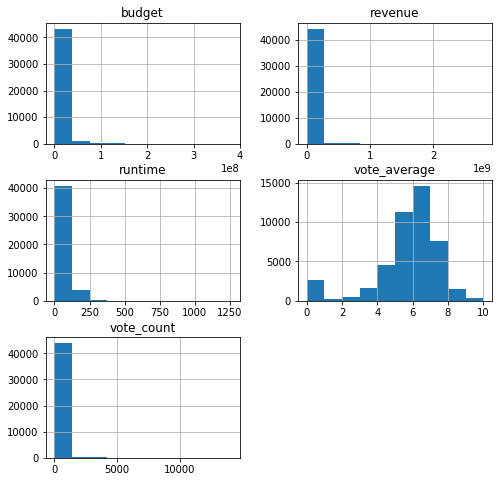

In [86]:
print(movie_df.shape)
_ = movie_df.hist(figsize=(8,8))

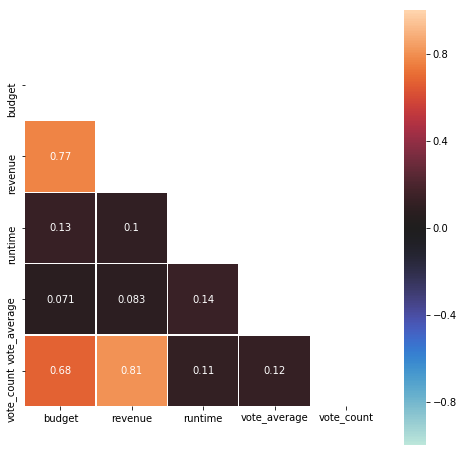

In [87]:
# A quick heatmap. It seems revenue and the number of votes are correlated.
import seaborn as sns
corr = movie_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 8))
_ = sns.heatmap(corr, vmax=1, vmin=-1, mask=mask, square=True, annot=True, linewidths=0.2, center=0)

In [88]:
# Toy Story Entry Example, looking it up by ID number
print(movie_df.loc[862])

belongs_to_collection                                 Toy Story Collection
budget                                                            30000000
genres                                         [Animation, Comedy, Family]
homepage                                                                 1
original_language                                                       en
overview                 Led by Woody, Andy's toys live happily in his ...
poster_path              <img src='http://image.tmdb.org/t/p/w185//rhIR...
production_companies                             [Pixar Animation Studios]
production_countries                            [United States of America]
release_date                                                    10/30/1995
revenue                                                        3.73554e+08
runtime                                                                 81
spoken_languages                                                 [English]
tagline                  

In [18]:
actors = []
num_movies = []
revenue_avg = []
counter = 0
for index, row in movie_df.iterrows():
    cast = row[20]
    revenue = row[10]
    for person in cast:
        try:
            index = actors.index(person)
        except:
            index = -1
        if(index != -1):
            temp = revenue_avg[index] * num_movies[index]
            temp += revenue
            num_movies[index] += 1
            revenue_avg[index] = temp/num_movies[index]
        else:
            actors.append(person)
            num_movies.append(1)
            revenue_avg.append(revenue)
        if(counter%10000 == 0):
            print(counter)
        counter += 1

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000


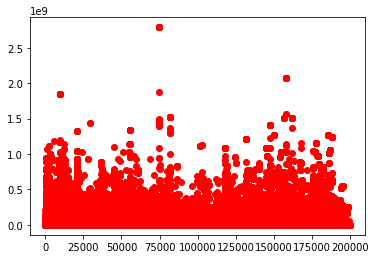

In [19]:
x = []
for i in range(0,len(actors)):
    x.append(i)
plt.plot(x,revenue_avg, 'ro')
plt.show()

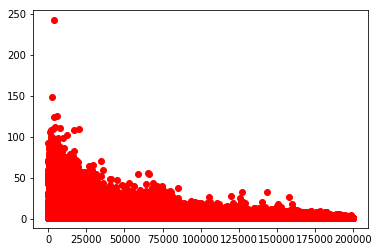

In [20]:
plt.plot(x,num_movies, 'ro')
plt.show()

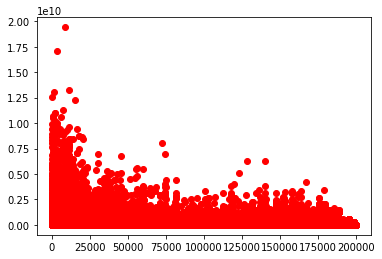

In [21]:
shifted_revenue = []
for i in range(0,len(revenue_avg)):
    shifted_revenue.append(revenue_avg[i] * num_movies[i])
plt.plot(x,shifted_revenue, 'ro')
plt.show()

In [22]:
shift_idx = shifted_revenue.index(max(shifted_revenue))
print(actors[shift_idx])
print(num_movies[shift_idx])
print(revenue_avg[shift_idx])
print(shifted_revenue[shift_idx])

Stan Lee
49
396223623.5714286
19414957555.0


In [23]:
idx = revenue_avg.index(max(revenue_avg))
print(actors[idx])
print(num_movies[idx])
print(revenue_avg[idx])
idx2 = num_movies.index(max(num_movies))
print(actors[idx2])
print(num_movies[idx2])
print(revenue_avg[idx2])
idx3 = actors.index("Tom Hanks")
print(actors[idx3])
print(num_movies[idx3])
print(revenue_avg[idx3])
idx4 = actors.index("Sam Worthington")
print(actors[idx4])
print(num_movies[idx4])
print(revenue_avg[idx4])

Sean Anthony Moran
1
2787965087.0
Bess Flowers
242
1524434.9545454553
Tom Hanks
72
138001974.58333334
Sam Worthington
28
153375273.0


In [89]:
print(movie_df.loc[862]['belongs_to_collection'])

Toy Story Collection


In [90]:
print(movie_df.loc[862]['cast'])

['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim Varney', 'Wallace Shawn', 'John Ratzenberger', 'Annie Potts', 'John Morris', 'Erik von Detten', 'Laurie Metcalf', 'R. Lee Ermey', 'Sarah Freeman', 'Penn Jillette']


In [98]:
# We could only do movies where the original language is English.
movie_df.loc[movie_df['original_language'] == 'en'].shape

(32199, 20)